# Step 1 - Model Training

Now that we have a feel for the data we are dealing with, we can start designing our model. In this notebook, we will define the network architecture and train the model. We will also discuss some of the transformations on the data in response to observations that we made in the data exploration section of the notebook.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers import BatchNormalization
from keras.layers import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from keras.utils import plot_model
# from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt

# << The directory containing the cooked data from the previous step >>
COOKED_DATA_DIR = 'output_data'

# << The directory in which the model output will be placed >>
MODEL_OUTPUT_DIR = 'model'

Let's read in the datasets from the exploration phase. If these do not exist, run the snippet from the [previous](DataExplorationAndPreparation.ipynb) notebook to generate them.

In [2]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

For image data, it is too expensive to load the entire dataset into memory. Fortunatly, Keras has the concept of DataGenerators. A DataGenerator is nothing more than an iterator that will read data from disk in chunks. This allows you to keep both your CPU and GPU busy, increasing throughput. 

We made a few observations during the exploration phase. Now let's come up with a strategy to incorporate them in our training algorithm:
* **Only a small portion of the image is of interest** - when generating batches, we can remove the pieces of the image that are not of interest.
* **The dataset exhibits vertical flip tolerance** - when generating batches, we can randomly flip some images and labels around the Y axis so the model has new data to learn from.
* **The dataset should be invariant to changes in lighting** - when generating batches, we can randomly add or remove brightness from the images so the model can learn that global changes in lighting should be ignored.
* **The dataset has a high proportion of zero-valued images** - when generating batches, we can randomly drop a percentage of data points where the steering angle is zero so the model sees a balanced dataset when training.
* **We need examples from the swerving strategy in our dataset so the model learns how to turn sharply** - we took care of this in the preprocessing phase.

While Keras does have some standard built-in transforms for images, they are not sufficient for our purpose. For example, when using horizontal_flip = True in the standard ImageDataGenerator, the signs of the labels are not inverted. Fortunatly, we can just extend the ImageDataGenerator class and implement our own transform logic. The code to do so is in Generator.py - it is straightforward, but too long to include in this notebook.

Here, we will initialize the generator with the following parameters:
* **Zero_Drop_Percentage: 0.9** - That is, we will randomly drop 90% of the data points with label = 0
* **Brighten_Range: 0.4** - That is, the brighness of each image will be modified by up to 40%. To compute "brightness", we transform the image from RGB to HSV space, scale the 'V' coordinate up or down, and transform back to RGB space.
* **ROI: [76,135,0,255]** - This is the x1, x2, y1, y2 rectangle that represents the area of interest for the images.


In [13]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,140,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[76,140,0,255])    

Let's look at a sample batch. The steering angle is represented by the red line in the image:

Actual Steering Angle = [-0.052668]


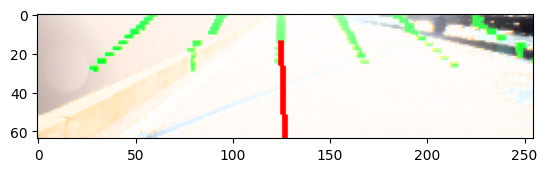

Actual Steering Angle = [0.0900817]


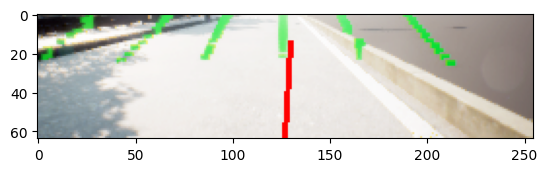

Actual Steering Angle = [0.00593856]


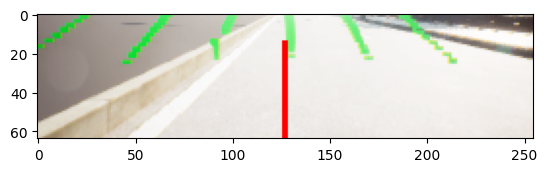

In [14]:
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

Next, let's define the network architecture. We will use a standard combination of convolutional / max pooling layers to process the images (we cannot go into the details of what each of these layers do here, but you should definitely check out the book mentioned in the readme file if you do not understand what is going on). Then, we will inject the vehicle's last known state into the dense layer as an additional feature. The layer sizes and optimization parameters were determined experimentally - try tweaking them and see what happens!

In [15]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Let's look at a summary of our model

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 255, 3)]         0         []                            
                                                                                                  
 convolution0 (Conv2D)       (None, 64, 255, 16)          448       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 32, 127, 16)          0         ['convolution0[0][0]']        
 g2D)                                                                                             
                                                                                                  
 convolution1 (Conv2D)       (None, 32, 127, 32)          4640      ['max_pooling2d_3[0][0]'

That's a lot of parameters! Fortunately, we have our data augmentation strategies, so the network has a chance of converging. Try adding / removing layers or changing their widths to see what effect it has on the number of trainable parameters in the network.

One of the nice features of Keras is the ability to declare callbacks. These functions get executed after each epoch of training. We will define a few callbacks:

* **ReduceLrOnPlateau** - If the model is near a minimum and the learning rate is too high, then the model will circle around that minimum without ever reaching it. This callback will allow us to reduce the learning rate when the validation loss stops improving, allowing us to reach the optimal point.
* **CsvLogger** - This lets us log the output of the model after each epoch, which will allow us to track the progress without needing to use the console.
* **ModelCheckpoint** - Generally, we will want to use the model that has the lowest loss on the validation set. This callback will save the model each time the validation loss improves.
* **EarlyStopping** - We will want to stop training when the validation loss stops improving. Otherwise, we risk overfitting. This monitor will detect when the validation loss stops improving, and will stop the training process when that occurs.

In [22]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback]

It's time to train the model! With the default setup, this model takes ~45 min to train on an NVidia GTX970 GPU. Note: sometimes the model will get stuck with a constant validation loss for up to 7 epochs. If left to run, the model should terminate with a validation loss of approximately .0003.

In [23]:
history = model.fit(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=500, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=1)

Epoch 1/500
22/22 [==============================] - ETA: 0s - loss: 0.0517
Epoch 1: val_loss improved from inf to 0.04874, saving model to model1\models\model_model.01-0.0487397.h5
22/22 [==============================] - 2s 104ms/step - loss: 0.0517 - val_loss: 0.0487 - lr: 1.0000e-04
Epoch 2/500
22/22 [==============================] - ETA: 0s - loss: 0.0516
Epoch 2: val_loss improved from 0.04874 to 0.04857, saving model to model1\models\model_model.02-0.0485705.h5
22/22 [==============================] - 2s 93ms/step - loss: 0.0516 - val_loss: 0.0486 - lr: 1.0000e-04
Epoch 3/500
22/22 [==============================] - ETA: 0s - loss: 0.0520
Epoch 3: val_loss did not improve from 0.04857
22/22 [==============================] - 2s 93ms/step - loss: 0.0520 - val_loss: 0.0489 - lr: 1.0000e-04
Epoch 4/500
22/22 [==============================] - ETA: 0s - loss: 0.0515
Epoch 4: val_loss did not improve from 0.04857
22/22 [==============================] - 2s 95ms/step - loss: 0.0515 -

Let's do a quick sanity check. We'll load a few training images and compare the labels and the predictions. These should be very close in value if our model has learned properly.

1/1 [==============================] - 0s 35ms/step
Actual Steering Angle = [0.0049266]
Predicted Steering Angle = [-0.00659186]
L1 Error: [0.01151846]


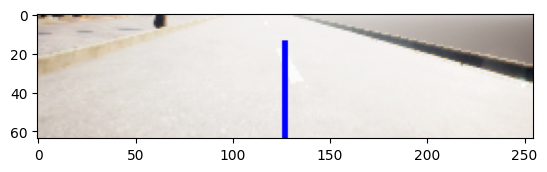

Actual Steering Angle = [-0.219893]
Predicted Steering Angle = [-0.00728109]
L1 Error: [0.21261191]


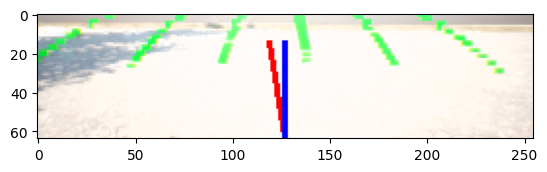

Actual Steering Angle = [0.052668]
Predicted Steering Angle = [-0.00531567]
L1 Error: [0.05798367]


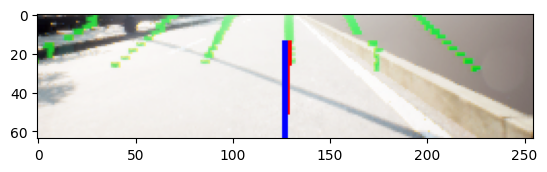

In [20]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])